In [1]:
import sys
import multiprocessing as mp

import matplotlib.pyplot as plt
from PIL import Image

import cv2 as cv

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

from src.utils.dataset import download_dataset, split_dataset, dataset_stats, TransformsDataset
from src.utils.visual import show_tensor
from src.utils.training import *
from src.models import Dreamnet50, Googledream
from src.deepdream_aux import *
from src.deepdream import *
from src.utils.headers import DREAM_CONFIG, IMAGENET_MEAN, IMAGENET_STD

# Import data

In [2]:
image_folder = download_dataset() + '/images/'
dataset = datasets.ImageFolder(image_folder)
train_data, val_data, test_data, dataset_sizes = split_dataset(
    dataset, 0.8, 0.5)
print(str(dataset_sizes))

{'train': 11118, 'val': 1390, 'test': 1390}


# Apply transforms

In [3]:
img_height = 224
img_width = 448
resize = transforms.Resize((img_height, img_width))
tensorfy = transforms.ToTensor()
transforms_pre_norm = transforms.Compose([resize, tensorfy])
train_data_pre_norm = TransformsDataset(train_data, transforms_pre_norm)

# Set up device and workers

In [4]:
# start by setting up device
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# number of threads to handle data. bug makes ipynb hang when num > 0 on windows.
if sys.platform == "linux" or device == 'cpu':
    num_workers = mp.cpu_count()
else:
    num_workers = 0

# Standardize data

In [5]:
mean, std = dataset_stats(train_data_pre_norm)
print(mean,std)

normalize = transforms.Normalize(mean, std)
transforms_norm = transforms.Compose([transforms_pre_norm, normalize])
train_data_norm = TransformsDataset(train_data_pre_norm, normalize)
val_data_norm = TransformsDataset(val_data, transforms_norm)
test_data_norm = TransformsDataset(test_data, transforms_norm)

#train_transform, test_transform = augmentation_1(int(img_height/0.95), int(img_width/0.95), 0.95, 3, mean, std)
#train_data_norm = TransformsDataset(train_data, train_transform)
#val_data_norm = TransformsDataset(val_data, test_transform)
#test_data_norm = TransformsDataset(test_data, test_transform)

[0.8442649  0.82529384 0.82333773] [0.28980458 0.32252666 0.3240354 ]


# Initialize batch loaders

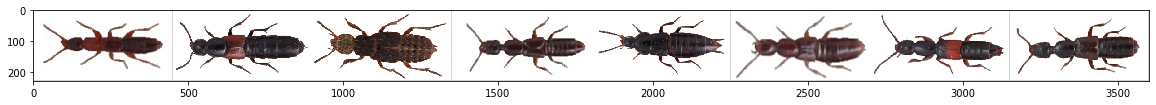

In [6]:
batch_size = 8
train_loader = torch.utils.data.DataLoader(train_data_norm, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data_norm, batch_size=batch_size,
                                         num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data_norm, batch_size=batch_size,
                                          num_workers=num_workers)
data_loaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

iterable = iter(train_loader)
images, labels = next(iterable)
img_grid = make_grid(images, nrow=8)
show_tensor(img_grid, mean, std, figsize = (20,20))

# Define classification model

In [7]:
model = models.resnet50(pretrained=False)
#model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=False, 
                        #transform_input = False, init_weights = True, aux_logits = True)
num_fc = model.fc.in_features

# were just counting the number of classes by counting subfolders in image folder
num_classes = len(next(os.walk(image_folder))[1])
model.fc = nn.Linear(num_fc, num_classes)
# used for later
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, eps=0.1)

# Train and or load classification model

In [8]:
load = False
train = True
if load == True:
    [metrics, [acc]] = load_model(model, name = 'model_resnet50_full_train', 
        get_test_scores = True,get_train_metrics = True, device = device)
    print(("test accuracy = %.2f %%" % (acc) ))
if train == True:
    metrics = fit(model, data_loaders, dataset_sizes, criterion, 
                  optimizer,  EarlyStopping(patience = 100), device=device)
    acc = test_model(model, data_loaders['test'])
    save_model(model, name = 'model_resnet50_full_train', train_metrics = metrics, 
                test_scores = np.array([acc]))
_ = model.eval()
plot_metrics(metrics)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 2.94 GiB total capacity; 1.73 GiB already allocated; 15.62 MiB free; 1.75 GiB reserved in total by PyTorch)

# Expose layers

In [ ]:
dreamnet = Googledream(model)
#dreamnet = Dreamnet50(model)
dreamnet.eval()
print(dreamnet.layers.keys())

dict_keys(['conv1', 'maxpool1', 'conv2', 'conv3', 'maxpool2', 'inception3a', 'inception3b', 'maxpool3', 'inception4a', 'inception4b', 'inception4c', 'inception4d', 'inception4e', 'maxpool4', 'inception5a', 'inception5b', 'avgpool', 'dropout', 'fc'])


# Lets dream!

## Choose image

In [ ]:
species_name = 'achenium_humile'
image_name = '_0189_0'
image_path = image_folder + species_name + '/' + image_name + '.jpg'
print(image_path)
input_image = cv.imread(image_path)[:, :, ::-1]

./data/beetles/images/achenium_humile/_0189_0.jpg


## Choose parameters and apply method

KeyboardInterrupt: 

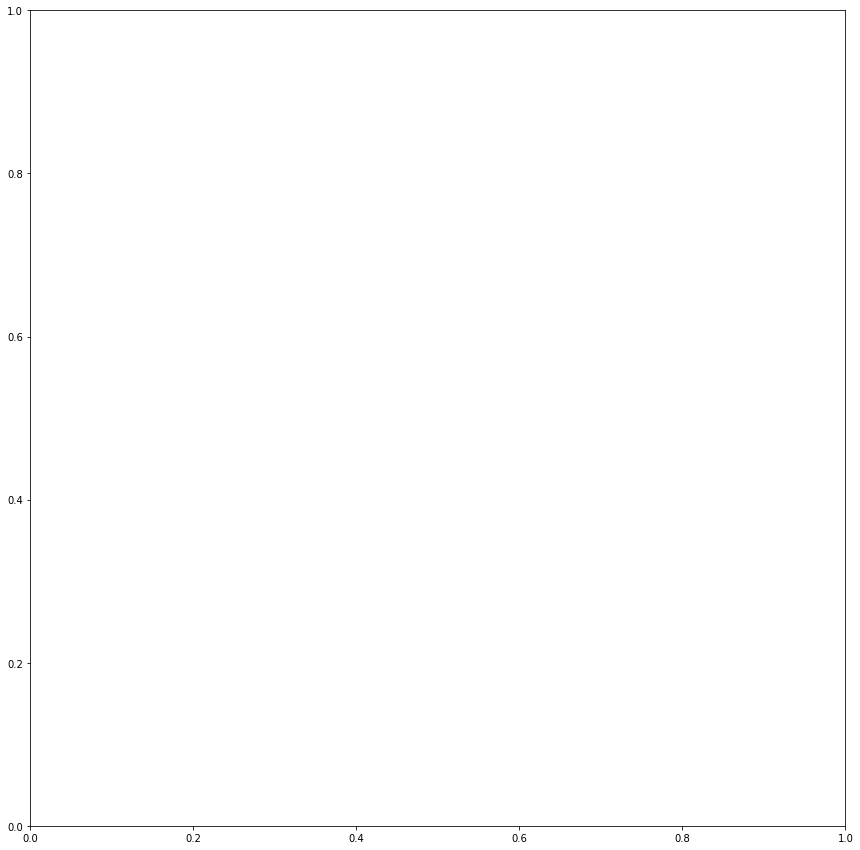

In [ ]:
params = {
    'mean': mean,
    'std': std,
    'out_info': [('fc', 40)],
    #'num_iters': 30,
    #'lr': 0.1,
    #'smooth_coef': 0,
    'device': device,
    #'use_noise': 'gaussian'
}
save_path = species_name + image_name
config = copy.deepcopy(DREAM_CONFIG)
for (name, param) in params.items():
    save_path += ('_' + name + '_' + str(param))
    config[name] = param

img_path = 'figures/' + save_path + '.jpg'
video_path = 'videos/' + save_path + '.gif'
config['img_path'] = img_path
config['video_path'] = video_path

dream_tensors = dreamspace(input_image, dreamnet, config)